#### Import modules

In [1]:
import sys
import os
from numpy import arange
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import savefig
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

utils_path = os.path.abspath(os.path.join('..', 'utils'))
sys.path.append(utils_path)

from dslabs_functions import ts_aggregation_by, series_train_test_split, plot_forecasting_eval, plot_forecasting_series, series_train_test_split
from dslabs_functions import HEIGHT, plot_multiline_chart
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart

#### Load data

In [2]:
data_path = os.path.abspath(os.path.join('..','..', 'data_copy/forecast_ny_arrests.csv'))
if not os.path.exists(data_path):
    print("File not found")
    data_path = os.path.abspath(os.path.join('..','..', 'data/f_s_forecast_ny_arrests.csv'))

def load_data(data_path):
    data: DataFrame = read_csv(
        data_path,
        index_col="Date",
        sep=";",
        decimal=".",
        parse_dates=True,
        infer_datetime_format=True,
    )
    return data

all_data = load_data(data_path)
file_tag = "ARREST"
target = "Manhattan"



data = all_data[[target]]


File not found


In [3]:
from pandas import DataFrame

def dataframe_train_test_split(data: DataFrame, trn_pct: float = 0.90) -> tuple[DataFrame, DataFrame]:
    trn_size = int(len(data) * trn_pct)
    train = data.iloc[:trn_size]
    test = data.iloc[trn_size:]
    return train, test


#### Preparation

In [4]:
import pandas as pd

def data_preparation(data):
    # Handle missing values
    data: DataFrame = data.dropna(how="any", inplace=False)
    
    # Train/test split
    train, test = dataframe_train_test_split(data)
    
    # Scaling (fit on train, transform both train and test)
    scaler: MinMaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(train)
    train_scaled = DataFrame(scaler.transform(train), index=train.index, columns=train.columns)
    test_scaled = DataFrame(scaler.transform(test), index=test.index, columns=test.columns)

    # Smoothing (apply only to train data)
    WIN_SIZE = 10
    train_smooth: DataFrame = train_scaled.rolling(window=WIN_SIZE).mean().dropna()

    # Differentiation (apply to smoothed train and original scaled test data)
    train_diff: DataFrame = train_smooth.diff().dropna()
    test_diff: DataFrame = test_scaled.diff().dropna()

    return train_diff, test_diff
def data_preparation(data):
    # Missing value 
    data: DataFrame = data.dropna(how="any", inplace=False) 
    # Train/test split
    train, test = dataframe_train_test_split(data)   

    # Smoothing
    WIN_SIZE = 10
    WIN_SIZE = 1
    train_smooth: Series = train.rolling(window=WIN_SIZE).mean()
    train_smooth = train_smooth.dropna()

    # Differentiation
    train_diff: Series = train_smooth.diff()
    train_diff = train_diff.dropna()
    test_diff: Series = test.diff()
    test_diff = test_diff.dropna()

    return train_diff, test_diff
    
    
train_target, test_target = data_preparation(data)

train_all, test_all = data_preparation(all_data)


print(train_target.columns, test_target.columns)
print(train_all.columns, test_all.columns)

Index(['Manhattan'], dtype='object') Index(['Manhattan'], dtype='object')
Index(['Bronx', 'Brooklyn', 'Queens', 'StatenIsland', 'Manhattan'], dtype='object') Index(['Bronx', 'Brooklyn', 'Queens', 'StatenIsland', 'Manhattan'], dtype='object')


In [5]:
from torch import no_grad, tensor
from torch.nn import LSTM, Linear, Module, MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset


def prepare_dataset_for_lstm(series, seq_length: int = 4):
    setX: list = []
    setY: list = []
    for i in range(len(series) - seq_length):
        past = series[i : i + seq_length]
        future = series[i + 1 : i + seq_length + 1]
        setX.append(past)
        setY.append(future)
    return tensor(setX), tensor(setY)


class DS_LSTM(Module):
    def __init__(self, train, input_size: int = 1, hidden_size: int = 50, num_layers: int = 1, length: int = 4):
        super().__init__()
        self.lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = Linear(hidden_size, 1)
        self.optimizer = Adam(self.parameters())
        self.loss_fn = MSELoss()

        trnX, trnY = prepare_dataset_for_lstm(train, seq_length=length)
        self.loader = DataLoader(TensorDataset(trnX, trnY), shuffle=True, batch_size=len(train) // 10)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

    def fit(self):
        self.train()
        for batchX, batchY in self.loader:
            y_pred = self(batchX)
            loss = self.loss_fn(y_pred, batchY)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return loss

    def predict(self, X):
        with no_grad():
            y_pred = self(X)
        return y_pred[:, -1, :]

In [6]:
# train_all.reset_index(drop=True, inplace=True)
train_all

,Bronx,Brooklyn,Queens,StatenIsland,Manhattan
Date,,,,,
2006-01-11,0.053620,0.034496,0.020380,0.021698,0.033069
2006-01-12,0.045023,0.014341,0.047554,0.019811,0.037030
2006-01-13,0.019910,0.019767,0.015761,0.011321,0.020594
2006-01-14,-0.013801,-0.025581,-0.019293,-0.015094,-0.018812
2006-01-15,-0.059729,-0.043798,-0.039402,-0.033962,-0.046337
...,...,...,...,...,...
2020-05-21,0.006561,0.009109,0.013043,-0.006604,0.012277
2020-05-22,-0.002941,0.003101,0.006250,-0.015094,-0.006139
2020-05-23,-0.006787,-0.015504,-0.007065,-0.005660,-0.008713


In [7]:
train_all_series = train_all.values.astype("float32")
test_all_series = test_all.values.astype("float32")

In [8]:
input_size = train_all_series.shape[1]
model = DS_LSTM(train_all_series, input_size=input_size, hidden_size=50, num_layers=1)
loss = model.fit()
print(loss)

tensor(0.0007, grad_fn=<MseLossBackward0>)


seq length=2 hidden_units=25 nr_episodes=0 -0.0185927152633667
seq length=2 hidden_units=25 nr_episodes=1 -0.013914227485656738
seq length=2 hidden_units=25 nr_episodes=2 -0.013672947883605957
seq length=2 hidden_units=25 nr_episodes=3 -0.014034628868103027
seq length=2 hidden_units=25 nr_episodes=4 -0.013872504234313965
seq length=2 hidden_units=25 nr_episodes=5 -0.016506314277648926
seq length=2 hidden_units=25 nr_episodes=6 -0.01480567455291748
seq length=2 hidden_units=25 nr_episodes=7 -0.015594244003295898
seq length=2 hidden_units=25 nr_episodes=8 -0.01631951332092285
seq length=2 hidden_units=25 nr_episodes=9 -0.016331791877746582
seq length=2 hidden_units=25 nr_episodes=10 -0.016076087951660156
seq length=2 hidden_units=50 nr_episodes=0 0.0007922053337097168
seq length=2 hidden_units=50 nr_episodes=1 0.0022507905960083008
seq length=2 hidden_units=50 nr_episodes=2 0.0008159875869750977
seq length=2 hidden_units=50 nr_episodes=3 -0.0010477304458618164
seq length=2 hidden_units=5

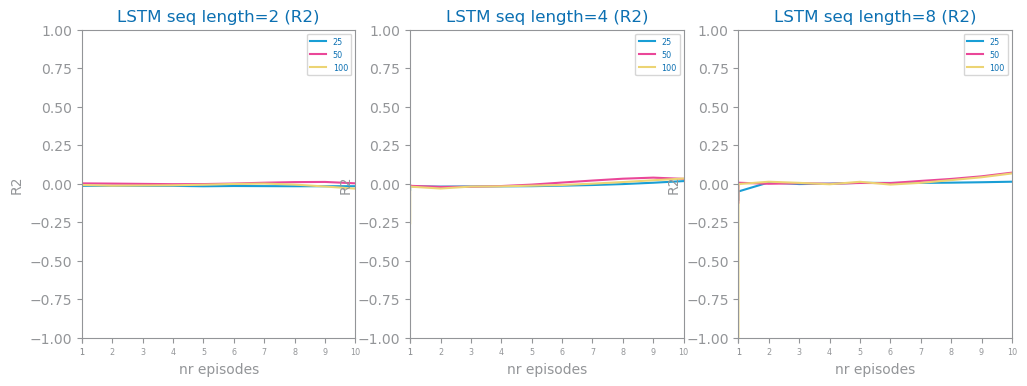

In [9]:
from copy import deepcopy

from matplotlib.pyplot import figure, savefig, subplots


def lstm_study(train, test, nr_episodes: int = 1000, measure: str = "R2"):
    input_size = train.shape[1]
    
    sequence_size = [2, 4, 8]
    nr_hidden_units = [25, 50, 100]

    step: int = nr_episodes // 10
    episodes = [1] + list(range(0, nr_episodes + 1, step))[1:]
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "LSTM", "metric": measure, "params": ()}
    best_performance: float = -100000

    _, axs = subplots(1, len(sequence_size), figsize=(len(sequence_size) * HEIGHT, HEIGHT))
    
    for i in range(len(sequence_size)):
        length = sequence_size[i]
        tstX, tstY = prepare_dataset_for_lstm(test, seq_length=length)
        
        values = {}
        for hidden in nr_hidden_units:
            yvalues = []
            model = DS_LSTM(train, hidden_size=hidden, input_size=input_size)
            for n in range(0, nr_episodes + 1):
                model.fit()
                if n % step == 0:
                    prd_tst = model.predict(tstX)
                    
                    # this is new. 
                    test_formatted = test[:,-1]
                    
                    eval: float = FORECAST_MEASURES[measure](test_formatted[length:], prd_tst)
                    print(f"seq length={length} hidden_units={hidden} nr_episodes={n}", eval)
                    if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                        best_performance: float = eval
                        best_params["params"] = (length, hidden, n)
                        best_model = deepcopy(model)
                    yvalues.append(eval)
            values[hidden] = yvalues
        plot_multiline_chart(
            episodes,
            values,
            ax=axs[i],
            title=f"LSTM seq length={length} ({measure})",
            xlabel="nr episodes",
            ylabel=measure,
            percentage=flag,
        )
    print(
        f"LSTM best results achieved with length={best_params['params'][0]} hidden_units={best_params['params'][1]} and nr_episodes={best_params['params'][2]}) ==> measure={best_performance:.2f}"
    )
    return best_model, best_params

measure: str = "R2"

train = train_all.values.astype("float32")
test = test_all.values.astype("float32")



best_model, best_params = lstm_study(train, test, nr_episodes=10, measure=measure)

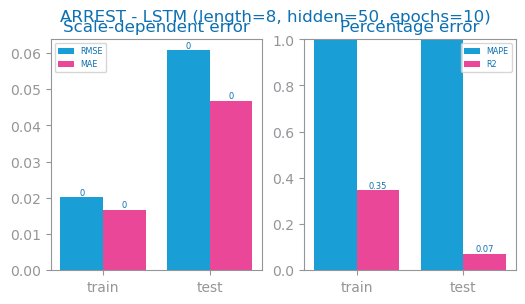

In [15]:
utils_path = os.path.abspath(os.path.join('..', 'utils'))
sys.path.append(utils_path)
from dslabs_functions import plot_forecasting_eval

train = train_all.values.astype("float32")
test = test_all.values.astype("float32")
params = best_params["params"]
best_length = params[0]
trnX, trnY = prepare_dataset_for_lstm(train, seq_length=best_length)
tstX, tstY = prepare_dataset_for_lstm(test, seq_length=best_length)

# Get the last cloumn of the test sets
# example test_formatted = test[:,-1]

train_eval = train[:,-1]
test_eval = test[:,-1]

prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)

plot_forecasting_eval(
    train_eval[best_length:],
    test_eval[best_length:],
    prd_trn,
    prd_tst,
    title=f"{file_tag} - LSTM (length={best_length}, hidden={params[1]}, epochs={params[2]})",
)
savefig(f"images/{file_tag}_lstms_{measure}_eval.png")

In [11]:
utils_path = os.path.abspath(os.path.join('..', 'utils'))
sys.path.append(utils_path)

from dslabs_functions import plot_forecasting_series

# series = data[[target]]
train, test = train_target, test_target

print((best_length))

print(len(test.index[best_length+1:]))

print(len(prd_tst))
pred_series: Series = Series(prd_tst.numpy().ravel(), index=test.index[best_length:])


8
575
576


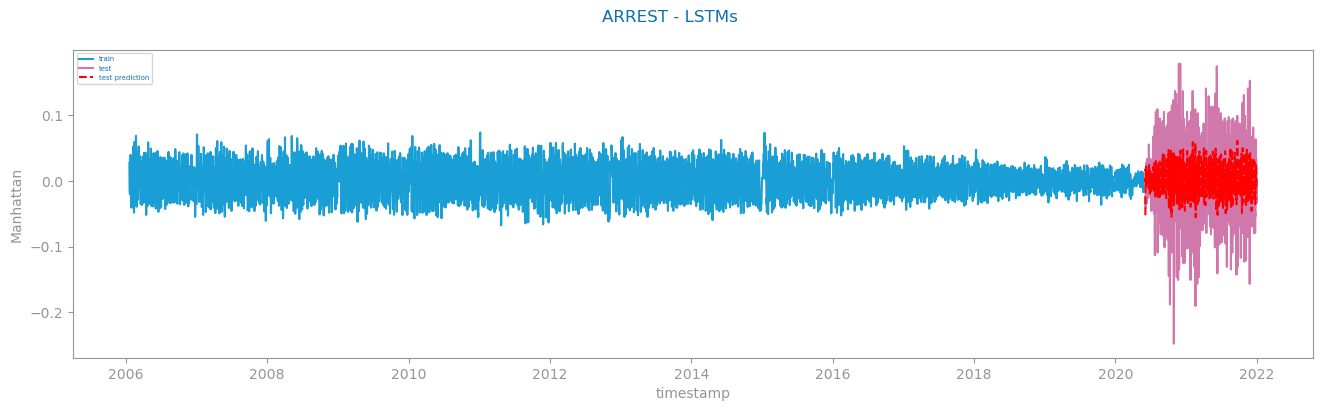

In [12]:

timecol: str = "timestamp"

plot_forecasting_series(
    train[best_length:],
    test[best_length:],
    pred_series,
    title=f"{file_tag} - LSTMs ",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}_lstms_{measure}_forecast.png")

In [13]:
best_params

{'name': 'LSTM', 'metric': 'R2', 'params': (8, 50, 10)}